## 1. Imports and Setup
First, we import the necessary libraries. We'll use TensorFlow and Keras for the model, `os` and `glob` for file handling, and OpenCV (`cv2`) for image processing and drawing bounding boxes during inference.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import glob
import cv2
from matplotlib import pyplot as plt

2025-08-27 18:28:36.634501: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2. Configuration
Set up the main configuration variables here. You should adjust `NUM_CLASSES` based on your specific dataset.

In [2]:
# Dataset paths (based on your image)
TRAIN_IMAGE_DIR = 'archive/images/train/'
TRAIN_LABEL_DIR = 'archive/labels/train/'
VAL_IMAGE_DIR = 'archive/images/val/'
VAL_LABEL_DIR = 'archive/labels/val/'

# Model and image parameters - Optimized for limited GPU memory
IMG_SIZE = 256  # Reduced from 512 to save memory
BATCH_SIZE = 1  # Keep at 1 for now
NUM_CLASSES = 2 # IMPORTANT: Change this to the number of classes in your dataset
EPOCHS = 5

## 3. Data Loading and Preprocessing
This function will parse the image and label directories to create a dataset. It reads the YOLO-style `.txt` files to get the bounding box coordinates and class labels. We then create a `tf.data.Dataset` for efficient training.

In [3]:
def parse_label_file(label_path):
    """Reads a YOLO-style label file and returns the class_id and bbox."""
    with open(label_path, 'r') as f:
        # Assuming one object per file for this simple model
        line = f.readline().strip().split()
        class_id = int(line[0])
        coords = np.array([float(x) for x in line[1:]], dtype=np.float32)
    return class_id, coords

def load_data(image_dir, label_dir):
    """Loads image paths and their corresponding labels."""
    image_paths = sorted(glob.glob(os.path.join(image_dir, '*.jpg'))) # Assuming .jpg, change if needed
    label_paths = sorted(glob.glob(os.path.join(label_dir, '*.txt')))
    
    labels = []
    for path in label_paths:
        class_id, bbox = parse_label_file(path)
        # One-hot encode the class ID
        one_hot_class = tf.keras.utils.to_categorical(class_id, num_classes=NUM_CLASSES)
        labels.append({'class': one_hot_class, 'bbox': bbox})
        
    return image_paths, labels

def data_generator(image_paths, labels):
    """A generator to load and preprocess images and labels."""
    for img_path, label in zip(image_paths, labels):
        # Load and resize image
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
        img = img / 255.0  # Normalize to [0, 1]
        
        yield img, (label['bbox'], label['class'])

# Create TensorFlow datasets
train_images, train_labels = load_data(TRAIN_IMAGE_DIR, TRAIN_LABEL_DIR)
val_images, val_labels = load_data(VAL_IMAGE_DIR, VAL_LABEL_DIR)

train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_images, train_labels),
    output_signature=(
        tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        (tf.TensorSpec(shape=(4,), dtype=tf.float32), tf.TensorSpec(shape=(NUM_CLASSES,), dtype=tf.float32))
    )
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(val_images, val_labels),
    output_signature=(
        tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        (tf.TensorSpec(shape=(4,), dtype=tf.float32), tf.TensorSpec(shape=(NUM_CLASSES,), dtype=tf.float32))
    )
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1756299527.285031   21041 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2606 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


## 4. Modified Object Detection Model
Here, we adapt your original `CNN_model`. The main change is at the end. Instead of one output layer, we create two separate 'heads':
1.  **`bbox_head`**: Predicts the 4 bounding box coordinates.
2.  **`class_head`**: Predicts the class of the object, just like in classification.

In [4]:
def ObjectDetector_model(num_classes, input_shape=(256, 256, 3)):  # Updated input shape
    # Input layer
    inputs = keras.layers.Input(shape=input_shape)
    
    # First convolutional block - Reduced filters
    x = keras.layers.Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding='same')(inputs)
    x = keras.layers.Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)

    # Second convolutional block - Reduced filters
    x = keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)

    # Third convolutional block - Reduced filters
    x = keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)

    # Fourth convolutional block - Reduced filters
    x = keras.layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = keras.layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)

    # Global Average Pooling instead of Flatten to reduce parameters
    x = keras.layers.GlobalAveragePooling2D()(x)

    # Reduced dense layers
    x = keras.layers.Dense(256, activation='relu')(x)  # Reduced from 512
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(128, activation='relu')(x)  # Reduced from 256
    x = keras.layers.Dropout(0.3)(x)

    # Bounding Box Head - predicts coordinates (x_center, y_center, width, height)
    bbox_head = keras.layers.Dense(4, activation='sigmoid', name='bbox')(x)

    # Classification Head - predicts the object class
    class_head = keras.layers.Dense(num_classes, activation='softmax', name='class')(x)

    # Create the final model
    model = keras.Model(inputs=inputs, outputs=[bbox_head, class_head])
    
    return model

# Instantiate the model
model = ObjectDetector_model(NUM_CLASSES)

## 5. Compiling and Training the Model
We compile the model with two different loss functions: `MeanSquaredError` for the bounding box regression and `CategoricalCrossentropy` for the classification. We can also assign different weights to each loss.
Then, we train the model using `model.fit()`.

In [5]:
# Define losses for each output head
losses = {
    'bbox': tf.keras.losses.MeanSquaredError(),
    'class': tf.keras.losses.CategoricalCrossentropy()
}

# Define weights for each loss
loss_weights = {
    'bbox': 1.0,
    'class': 1.0
}

# Define metrics for each output head
metrics = {
    'bbox': ['mae'],  # Mean Absolute Error for bounding box regression
    'class': ['accuracy']  # Accuracy for classification
}

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=losses,
    loss_weights=loss_weights,
    metrics=metrics
)

model.summary()

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ re_lu_2[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[

 Total params: 361,174 (1.38 MB)

 Trainable params: 360,694 (1.38 MB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/5


2025-08-27 18:29:34.552971: I external/local_xla/xla/service/service.cc:163] XLA service 0x2cb01400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-27 18:29:34.553022: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-08-27 18:29:34.654250: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-27 18:29:35.400023: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200
2025-08-27 18:29:35.400023: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200
2025-08-27 18:29:36.546527: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[1,128,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,32,32]{3,2,1,0

     13/Unknown 10s 14ms/step - bbox_loss: 0.1124 - bbox_mae: 0.2753 - class_accuracy: 0.7554 - class_loss: 0.4795 - loss: 0.5919

I0000 00:00:1756299580.696589   21092 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  13752/Unknown 206s 14ms/step - bbox_loss: 0.0620 - bbox_mae: 0.1994 - class_accuracy: 0.9993 - class_loss: 0.0027 - loss: 0.0648

2025-08-27 18:32:57.136795: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-27 18:32:57.137031: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/home/nizhal/Documents/CNN_Model/tfcnn/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13754/13754 ━━━━━━━━━━━━━━━━━━━━ 254s 18ms/step - bbox_loss: 0.0587 - bbox_mae: 0.1945 - class_accuracy: 0.9999 - class_loss: 5.3794e-04 - loss: 0.0593 - val_bbox_loss: 0.0567 - val_bbox_mae: 0.1914 - val_class_accuracy: 1.0000 - val_class_loss: 5.2518e-07 - val_loss: 0.0567
Epoch 2/5
Epoch 2/5
    9/13754 ━━━━━━━━━━━━━━━━━━━━ 2:52 13ms/step - bbox_loss: 0.0673 - bbox_mae: 0.2022 - class_accuracy: 1.0000 - class_loss: 2.3354e-06 - loss: 0.0673

2025-08-27 18:33:44.750420: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-08-27 18:33:44.750447: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13958036028458396345
2025-08-27 18:33:44.750453: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3972927965795361603
2025-08-27 18:33:44.750460: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6630040592523896342


13754/13754 ━━━━━━━━━━━━━━━━━━━━ 241s 18ms/step - bbox_loss: 0.0572 - bbox_mae: 0.1923 - class_accuracy: 1.0000 - class_loss: 1.3555e-06 - loss: 0.0572 - val_bbox_loss: 0.0568 - val_bbox_mae: 0.1910 - val_class_accuracy: 1.0000 - val_class_loss: 3.6299e-08 - val_loss: 0.0568
Epoch 3/5
13754/13754 ━━━━━━━━━━━━━━━━━━━━ 241s 18ms/step - bbox_loss: 0.0572 - bbox_mae: 0.1923 - class_accuracy: 1.0000 - class_loss: 1.3555e-06 - loss: 0.0572 - val_bbox_loss: 0.0568 - val_bbox_mae: 0.1910 - val_class_accuracy: 1.0000 - val_class_loss: 3.6299e-08 - val_loss: 0.0568
Epoch 3/5
    8/13754 ━━━━━━━━━━━━━━━━━━━━ 3:52 17ms/step - bbox_loss: 0.0673 - bbox_mae: 0.2014 - class_accuracy: 1.0000 - class_loss: 2.5485e-07 - loss: 0.0673

2025-08-27 18:37:45.683839: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-08-27 18:37:45.683881: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13958036028458396345
2025-08-27 18:37:45.683890: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3972927965795361603
2025-08-27 18:37:45.683909: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6630040592523896342


13754/13754 ━━━━━━━━━━━━━━━━━━━━ 240s 17ms/step - bbox_loss: 0.0571 - bbox_mae: 0.1921 - class_accuracy: 1.0000 - class_loss: 2.3718e-07 - loss: 0.0571 - val_bbox_loss: 0.0568 - val_bbox_mae: 0.1906 - val_class_accuracy: 1.0000 - val_class_loss: 0.0000e+00 - val_loss: 0.0568
Epoch 4/5
13754/13754 ━━━━━━━━━━━━━━━━━━━━ 240s 17ms/step - bbox_loss: 0.0571 - bbox_mae: 0.1921 - class_accuracy: 1.0000 - class_loss: 2.3718e-07 - loss: 0.0571 - val_bbox_loss: 0.0568 - val_bbox_mae: 0.1906 - val_class_accuracy: 1.0000 - val_class_loss: 0.0000e+00 - val_loss: 0.0568
Epoch 4/5
   10/13754 ━━━━━━━━━━━━━━━━━━━━ 2:58 13ms/step - bbox_loss: 0.0683 - bbox_mae: 0.2040 - class_accuracy: 1.0000 - class_loss: 6.4165e-08 - loss: 0.0683

2025-08-27 18:41:46.063292: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13958036028458396345
2025-08-27 18:41:46.063328: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3972927965795361603
2025-08-27 18:41:46.063347: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6630040592523896342


13754/13754 ━━━━━━━━━━━━━━━━━━━━ 241s 18ms/step - bbox_loss: 0.0570 - bbox_mae: 0.1921 - class_accuracy: 1.0000 - class_loss: 3.1219e-08 - loss: 0.0570 - val_bbox_loss: 0.0568 - val_bbox_mae: 0.1905 - val_class_accuracy: 1.0000 - val_class_loss: 0.0000e+00 - val_loss: 0.0568
Epoch 5/5
13754/13754 ━━━━━━━━━━━━━━━━━━━━ 241s 18ms/step - bbox_loss: 0.0570 - bbox_mae: 0.1921 - class_accuracy: 1.0000 - class_loss: 3.1219e-08 - loss: 0.0570 - val_bbox_loss: 0.0568 - val_bbox_mae: 0.1905 - val_class_accuracy: 1.0000 - val_class_loss: 0.0000e+00 - val_loss: 0.0568
Epoch 5/5
    5/13754 ━━━━━━━━━━━━━━━━━━━━ 4:09 18ms/step - bbox_loss: 0.0668 - bbox_mae: 0.1965 - class_accuracy: 1.0000 - class_loss: 0.0000e+00 - loss: 0.0668 

2025-08-27 18:45:47.229163: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-08-27 18:45:47.229219: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13958036028458396345
2025-08-27 18:45:47.229236: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3972927965795361603
2025-08-27 18:45:47.229272: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6630040592523896342


13754/13754 ━━━━━━━━━━━━━━━━━━━━ 234s 17ms/step - bbox_loss: 0.0570 - bbox_mae: 0.1920 - class_accuracy: 1.0000 - class_loss: 3.5796e-09 - loss: 0.0570 - val_bbox_loss: 0.0568 - val_bbox_mae: 0.1904 - val_class_accuracy: 1.0000 - val_class_loss: 0.0000e+00 - val_loss: 0.0568
13754/13754 ━━━━━━━━━━━━━━━━━━━━ 234s 17ms/step - bbox_loss: 0.0570 - bbox_mae: 0.1920 - class_accuracy: 1.0000 - class_loss: 3.5796e-09 - loss: 0.0570 - val_bbox_loss: 0.0568 - val_bbox_mae: 0.1904 - val_class_accuracy: 1.0000 - val_class_loss: 0.0000e+00 - val_loss: 0.0568


2025-08-27 18:49:41.474357: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13958036028458396345
2025-08-27 18:49:41.474406: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3972927965795361603
2025-08-27 18:49:41.474447: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6630040592523896342


## 6. Saving the Model
After training, we save the model in TensorFlow's standard `SavedModel` format. We also convert and save it as an `.onnx` file, as requested. You'll need to install the `tf2onnx` library for this step:

`pip install tf2onnx`

In [7]:
# Save in native Keras format (recommended)
KERAS_MODEL_PATH = 'object_detector_model.keras'
model.save(KERAS_MODEL_PATH)
print(f"Model saved in Keras format at: {KERAS_MODEL_PATH}")

# Save in TensorFlow SavedModel format (for deployment)
TF_MODEL_PATH = 'object_detector_model_tf'
model.export(TF_MODEL_PATH)
print(f"Model exported in TensorFlow SavedModel format at: {TF_MODEL_PATH}")

# Save in ONNX format
try:
    import tf2onnx
    ONNX_MODEL_PATH = 'object_detector_model.onnx'
    spec = (tf.TensorSpec((None, IMG_SIZE, IMG_SIZE, 3), tf.float32, name="input"),)
    model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13, output_path=ONNX_MODEL_PATH)
    print(f"Model saved in ONNX format at: {ONNX_MODEL_PATH}")
except ImportError:
    print("Could not save in ONNX format. Please run 'pip install tf2onnx'")
except Exception as e:
    print(f"ONNX conversion failed: {e}")

print("\n✅ Model saving completed!")
print("Available formats:")
print(f"  - Keras format: {KERAS_MODEL_PATH}")
print(f"  - TensorFlow SavedModel: {TF_MODEL_PATH}")
print(f"  - ONNX format: {ONNX_MODEL_PATH}")

Model saved in Keras format at: object_detector_model.keras
INFO:tensorflow:Assets written to: object_detector_model_tf/assets
INFO:tensorflow:Assets written to: object_detector_model_tf/assets


INFO:tensorflow:Assets written to: object_detector_model_tf/assets


Saved artifact at 'object_detector_model_tf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  List[TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)]
Captures:
  124202646942736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124202633990160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124202633991120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124202633991504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124202633991696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124202633991888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124202633990928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124202633990544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124202633989008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124202633988

I0000 00:00:1756301242.550308   21041 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1756301242.550446   21041 single_machine.cc:376] Starting new session
I0000 00:00:1756301242.555763   21041 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2606 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5
I0000 00:00:1756301242.667251   21041 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2606 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5
I0000 00:00:1756301242.684758   21041 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1756301242.684983   21041 single_machine.cc:376] Starting new session
I0000 00:00:1756301242.690273   21041 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:

Model saved in ONNX format at: object_detector_model.onnx

✅ Model saving completed!
Available formats:
  - Keras format: object_detector_model.keras
  - TensorFlow SavedModel: object_detector_model_tf
  - ONNX format: object_detector_model.onnx


## 7. Inference and Visualization
Finally, we'll create an inference function to test our trained model. This function will:
1. Load the saved TensorFlow model.
2. Preprocess a test image.
3. Get predictions from the model.
4. Convert the normalized coordinates back to pixel values.
5. Draw the bounding box and class label on the image using OpenCV.

Running inference on: archive/images/val/0000f8604a4e2cfe.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step


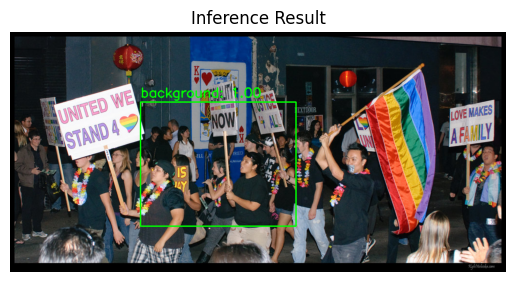

Running inference on: archive/images/val/0001e27f4b156f49.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step


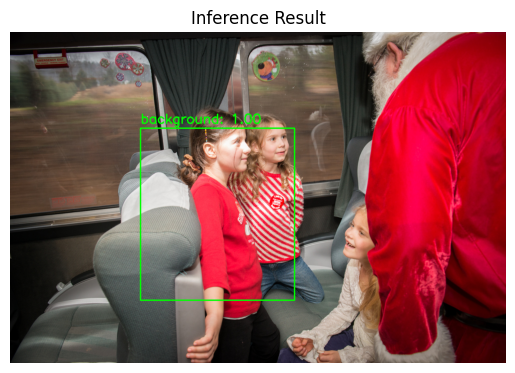

Running inference on: archive/images/val/00041668df0b3b25.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step


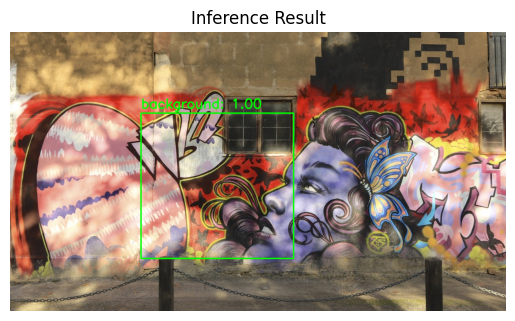

In [8]:
def run_inference(model_path, image_path, class_names):
    """Loads a model and an image, performs inference, and draws the bounding box."""
    # Load the model (works with both .keras and SavedModel formats)
    loaded_model = tf.keras.models.load_model(model_path)
    
    # Load and preprocess the image
    image_bgr = cv2.imread(image_path)
    original_h, original_w, _ = image_bgr.shape
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image_rgb, (IMG_SIZE, IMG_SIZE))
    image_normalized = image_resized / 255.0
    image_batch = np.expand_dims(image_normalized, axis=0) # Add batch dimension
    
    # Make predictions
    bbox_pred, class_pred = loaded_model.predict(image_batch)
    
    # Post-process the output
    bbox = bbox_pred[0] # Get the first (and only) prediction
    x_center, y_center, w, h = bbox
    
    # Denormalize coordinates
    x_min = int((x_center - w / 2) * original_w)
    y_min = int((y_center - h / 2) * original_h)
    x_max = int((x_center + w / 2) * original_w)
    y_max = int((y_center + h / 2) * original_h)
    
    # Find the predicted class
    predicted_class_id = np.argmax(class_pred[0])
    confidence = np.max(class_pred[0])
    class_label = class_names.get(predicted_class_id, 'Unknown')
    label_text = f'{class_label}: {confidence:.2f}'

    # Draw bounding box and label on the original image
    cv2.rectangle(image_bgr, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    cv2.putText(image_bgr, label_text, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    # Display the result
    plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
    plt.title('Inference Result')
    plt.axis('off')
    plt.show()

# --- Example Usage ---
# Update class names for people detection
CLASS_NAMES = {0: 'background', 1: 'person'} # Updated for people detection

# Get a few test images from the validation set
test_image_paths = val_images[:3] 

for img_path in test_image_paths:
    print(f"Running inference on: {img_path}")
    # Use the Keras format model for inference
    run_inference('object_detector_model.keras', img_path, CLASS_NAMES)